In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# --- Model Parameters ---
mu_max = 0.86980    # 1/h
Ks = 0.000123762    # g/l
Yxs = 0.435749      # g/g
Sin = 286           # g/l

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

T_START = 0
T_END = 5
dt = 0.1  # Time step
time = np.arange(T_START, T_END, dt)
SS = int((T_END - T_START) / dt)  # Number of time steps

F_min, F_max = 0, 0.1       # Feed bounds [L/h]

# Plant Model
def system_dynamics(t, y, F):
    X, S, V = y
    S = max(S, 0)
    mu = mu_max * S / (Ks + S)
    dXdt = mu * X - (F / V) * X
    dSdt = -(1 / Yxs) * mu * X + (F / V) * (Sin - S)
    dVdt = F
    return [dXdt, dSdt, dVdt]

setpoint = 25.0

# Αρχικοποίηση συστήματος
X = np.zeros(SS+1)
S = np.zeros(SS+1)
V = np.zeros(SS+1)
F_PID = np.zeros(SS)

X[0], S[0], V[0] = X_0, S_0, V_0

Kp = 1.5
Ki = 0.01
Kd = 0.05

def pid_controller(t: float, measured_value: float, setpoint: float):
    integral_error = 0.0
    prev_error = 0.0
    error = setpoint - measured_value
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    output = Kp * error + Ki * integral_error + Kd * derivative_error
    return np.clip(output, F_min, F_max)

for step in range(SS):
    t = step * dt
    F_PID[step] = pid_controller(t, X[step], setpoint)
    sol = solve_ivp(
        system_dynamics, [t, t + dt], 
        [X[step], S[step], V[step]], 
        args=(F_PID[step],), method='RK45'
    ) 
    X[step+1] = sol.y[0][-1]
    S[step+1] = sol.y[1][-1]
    V[step+1] = sol.y[2][-1]

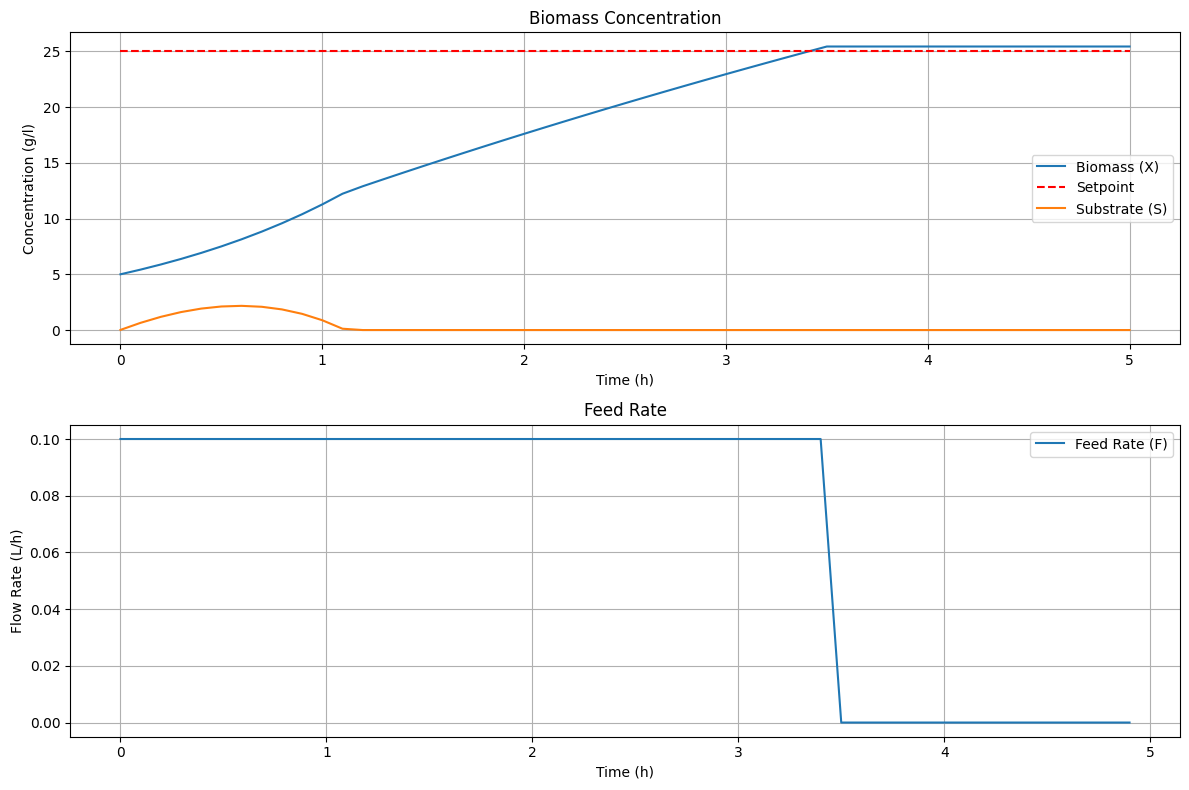

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(np.arange(0,5+dt,dt), X, label='Biomass (X)')
plt.plot(np.arange(0,5+dt,dt), [setpoint]*len(np.arange(0,5+dt,dt)), 'r--', label='Setpoint')
plt.plot(np.arange(0,5+dt,dt), S, label='Substrate (S)')
plt.title('Biomass Concentration')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(np.arange(0,5,dt), F_PID, label='Feed Rate (F)')
plt.title('Feed Rate')
plt.xlabel('Time (h)')
plt.ylabel('Flow Rate (L/h)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
